#Chapter 8

building a review classification tool

In [1]:
import spacy
import re

nlp = spacy.load('en_core_web_sm')
L = list(nlp.vocab.strings)


Example

In [2]:
import numpy as np
import pandas as pd
from collections import Counter
import re
import json

In [3]:


#with open('F:\\Users\\Luke\\Documents\\Git\\NPL\\NLP-Python-Beginners\\data\\yelp_academic_dataset_review.json', encoding="utf8") as json_file:      
#    data = json_file.readlines()
#    # this line below may take at least 8-10 minutes of processing for 4-5 million rows. It converts all strings in list to actual json objects. 
#    data = list(map(json.loads, data)) 

#df = pd.DataFrame(data)


#dont have csv
df = pd.read_csv('F:\\Users\\Luke\\Documents\\Git\\NPL\\NLP-Python-Beginners\\data\\Womens Clothing E-Commerce Reviews.csv');


#print(df)

#print(df.head());

#df.tail();

vocab = {};




def initializeVocabulary():
    unknownToken = '<UNKNOWN_TOKEN>'
    vocab['t_2_i'] = {}
    vocab['i_2_t'] = {}
    vocab['UNKNOWN_TOKEN'] = unknownToken;
    idx = addToken(unknownToken)
    vocab['UNKNOWN_TOKEN_INDEX'] = idx;

def addToken(token):
    if token in vocab['t_2_i']:
        idx = vocab['t_2_i'][token]
    else:
        idx = len(vocab['t_2_i'])
        vocab['t_2_i'][token] = idx
        vocab['i_2_t'][idx] = token
    return idx

def AddManyTokens(tokens):
    idxes = [addToken(token) for token in tokens];
    return idxes;
def lookupToken(token):
    if vocab['UNKNOWN_TOKEN_INDEX'] >= 0:
        return vocab['t_2_i'].get(token,vocab['UNKNOWN_TOKEN_INDEX'])
    else:
        return vocab['t_2_i'][token]
def lookupIndex(index):
    if index not in vocab['i_2_t']:
        raise KeyError("the index (%d) is not there" %index)
    return vocab['i_2_t'][index]
def vocabularyFromDataFrame(dataFrame,dataFrameCell='review',cutoff=25):
    initializeVocabulary()
    wordCounts = Counter()
    #df[dataFrameCell].fillna('').apply(str)

    for data in dataFrame[dataFrameCell].fillna('').apply(str):
        m = re.split('\W+',data)
        if(m != None):
            for word in m:
                wordCounts[word] += 1;
    for word,count in wordCounts.items():
        if count > cutoff:
            addToken(word)

def vocabularyFromCorpus(corpus,cutoff=25):
    initializeVocabulary()
    wordCounts = Counter()
    #df[dataFrameCell].fillna('').apply(str)

    for data in corpus:
        m = re.split('\W+',data)
        if(m != None):
            for word in m:
                wordCounts[word] += 1;
    for word,count in wordCounts.items():
        if count > cutoff:
            addToken(word)

#vocabularyFromDataFrame(df,'Review Text');

Corpus = np.asarray(df['Review Text'].fillna('').apply(str))
vocabularyFromCorpus(Corpus)

theIndex = lookupToken('the');
print(theIndex);
print(lookupIndex(theIndex));


36
the


One Hot Encoding

if len of vocob = 5
and index of word = 1
[01000]
of the index of word = 3
[00010]

etc...

In [4]:
def oneHotVector(token,length):
    oneHot = np.zeros((length,1))
    oneHot[lookupToken(token)] = 1;
    return oneHot

vocabLen = len(vocab['t_2_i'])
token = 'the'
oneHot = oneHotVector(token,vocabLen)

oneHot

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

r1: the food is good = 
0100
0010
1000
0001
r2: we will never visit this place again


In [5]:
def computeFeatures(document,length):
    isFirst = True
    print(document);
    for token in document:
        oneHot = oneHotVector(token,length)
        if isFirst:
            xF = oneHot
            isFirst = False
        else:
            xF = np.hstack((xF,oneHot))
    return np.mean(xF,axis=1)[:,np.newaxis]

featureVector = computeFeatures(Corpus[0],len(vocab['t_2_i']))
featureVector.shape

Absolutely wonderful - silky and sexy and comfortable


(2278, 1)

In [10]:
#reload data for clean start
df = pd.read_csv('F:\\Users\\Luke\\Documents\\Git\\NPL\\NLP-Python-Beginners\\data\\Womens Clothing E-Commerce Reviews.csv');

In [38]:
vocab = {};
def corpusToFeatureMatrix(corpus,length):
    isFirst = True
    for doc in corpus:
        if(len(doc) > 0):
            fv = computeFeatures(doc,length)
            if isFirst:
                fM = fv
                isFirst = False
            else:
                fM = np.hstack((fM,fv))
        return fM.T

def computeFeatures_fast(doc,N):
    fv = np.zeros(N)
    numTokens = 0
    for token in doc:
        fv[lookupToken(token)] += 1
        numTokens += 1
    return fv/numTokens

def corpusToFeatureMatrix_fast(Corpus,N):
    fM = np.zeros((N,len(Corpus)))
    i = 0
    for doc in Corpus:
        fM[:,i] = computeFeatures_fast(doc,N)
        i+=1
    return fM.T

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    print(indices_to_keep)
    return df[indices_to_keep].astype(np.float64)

##df = clean_dataset(df);

conditions = [
    df['Rating'] >= 4,
    df['Rating'] == 3,
    df['Rating'] <= 2,
]

values = ['Positive', 'Neutral', 'Negative']
df['Target'] = np.select(conditions, values)

reviewsX = np.asarray(df['Review Text'].fillna('').apply(str))
ratingsY = np.asarray(df['Target'].fillna('Neutral').apply(str))

#index = 0
#for i in ratingsY:
#    if i == np.nan:
#        print(index, i)
#    index +=1


from sklearn.model_selection import train_test_split
Xtrain,Xtest,Ytrain,YTest = train_test_split(reviewsX,ratingsY,test_size=0.3,shuffle=True)



vocabularyFromCorpus(Xtrain)
N = len(vocab['t_2_i'])
Xtrain_fM = corpusToFeatureMatrix_fast(Xtrain,N)
Xtest_fM = corpusToFeatureMatrix_fast(Xtest,N)

#print(Xtrain_fM)


if np.any(np.isnan(Xtrain_fM)):
    print("Xtrain_fM has Nan")

print(Xtrain_fM.shape)
#should get the same dimensionality (....,x) 
# x should be the same in both
print(Xtest_fM.shape)

(13763, 1822)
(5899, 1822)


Text(89.133125, 0.5, 'Predicted Label')

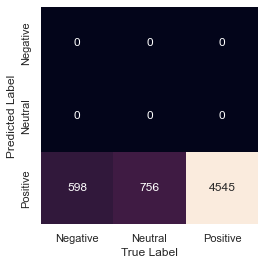

In [39]:
#from sklearn.linear_model import LogisticRegression as clf
#from sklearn.naive_bayes import GaussianNB as clf
#from sklearn.ensemble import RandomForestClassifier as clf

from sklearn.svm import SVC as clf
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
sns.set()






M = clf().fit(Xtrain_fM,Ytrain)

y_pred = M.predict(Xtest_fM)


mat = confusion_matrix(YTest,y_pred)
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False,
           xticklabels=np.unique(ratingsY),yticklabels=np.unique(ratingsY))
plt.xlabel("True Label")
plt.ylabel("Predicted Label")